# 马尔可夫链客户行为分析
# 案例2：使用马尔可夫链分析和预测客户购买行为

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 生成模拟客户数据

In [2]:
np.random.seed(123)

# 客户状态定义
customer_states = {
    0: '高频购买',    # 月购买次数 >= 4
    1: '低频购买',    # 1 <= 月购买次数 < 4
    2: '流失'         # 月购买次数 = 0
}

n_customers = 1000
n_months = 12

# 定义真实的客户行为转移概率
true_customer_matrix = np.array([
    [0.7, 0.2, 0.1],   # 高频 -> [高频, 低频, 流失]
    [0.2, 0.5, 0.3],   # 低频 -> [高频, 低频, 流失]
    [0.1, 0.2, 0.7]    # 流失 -> [高频, 低频, 流失]
])

In [3]:
def generate_customer_journey(n_months, initial_state=None):
    """生成单个客户的状态轨迹"""
    if initial_state is None:
        # 初始状态分布：60%低频，30%高频，10%流失
        initial_state = np.random.choice(3, p=[0.3, 0.6, 0.1])
    
    journey = [initial_state]
    current_state = initial_state
    
    for _ in range(n_months - 1):
        next_state = np.random.choice(3, p=true_customer_matrix[current_state])
        journey.append(next_state)
        current_state = next_state
    
    return journey

# 生成所有客户的购买历史

In [4]:
# 生成所有客户的购买历史
customer_data = []
for customer_id in range(n_customers):
    journey = generate_customer_journey(n_months)
    
    # 根据状态生成具体的购买次数
    purchase_counts = []
    for state in journey:
        if state == 0:  # 高频购买
            count = np.random.poisson(5) + 4  # 平均9次
        elif state == 1:  # 低频购买
            count = np.random.poisson(1.5) + 1  # 平均2.5次
        else:  # 流失
            count = 0
        purchase_counts.append(count)
    
    # 生成客户属性
    customer_info = {
        'customer_id': customer_id,
        'registration_months': np.random.randint(12, 36),
        'avg_order_value': np.random.normal(100, 30)
    }
    
    # 创建月度记录
    for month in range(n_months):
        record = customer_info.copy()
        record['month'] = month
        record['purchase_count'] = purchase_counts[month]
        record['state'] = journey[month]
        record['state_name'] = customer_states[journey[month]]
        customer_data.append(record)

# 创建数据框
df_customers = pd.DataFrame(customer_data)

print("客户数据概览：")
print(df_customers.head(10))
print(f"\n数据形状：{df_customers.shape}")
print(f"客户总数：{n_customers}")
print(f"时间跨度：{n_months}个月")

客户数据概览：
   customer_id  registration_months  avg_order_value  month  purchase_count  \
0            0                   28       151.313128      0               2   
1            0                   28       151.313128      1               3   
2            0                   28       151.313128      2               1   
3            0                   28       151.313128      3               3   
4            0                   28       151.313128      4               0   
5            0                   28       151.313128      5               0   
6            0                   28       151.313128      6               0   
7            0                   28       151.313128      7               0   
8            0                   28       151.313128      8               0   
9            0                   28       151.313128      9               0   

   state state_name  
0      1       低频购买  
1      1       低频购买  
2      1       低频购买  
3      1       低频购买  
4      2    

# 2. 数据探索性分析

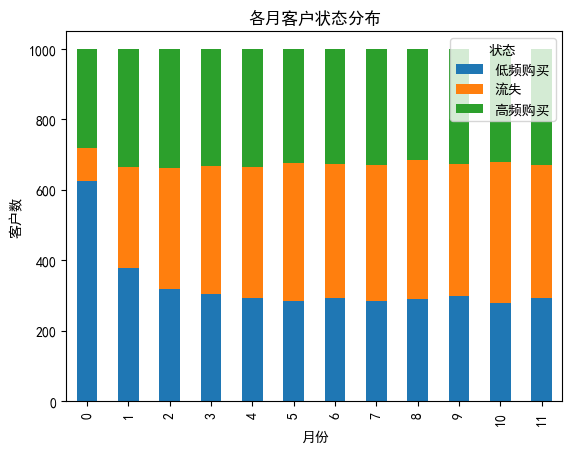

In [5]:

# plt.figure(figsize=(25, 10))

# 子图1：客户状态分布
# plt.subplot(2, 3, 1)
state_counts = df_customers.groupby('month')['state_name'].value_counts().unstack()
state_counts.plot(kind='bar', stacked=True)
plt.title('各月客户状态分布')
plt.xlabel('月份')
plt.ylabel('客户数')
plt.legend(title='状态')




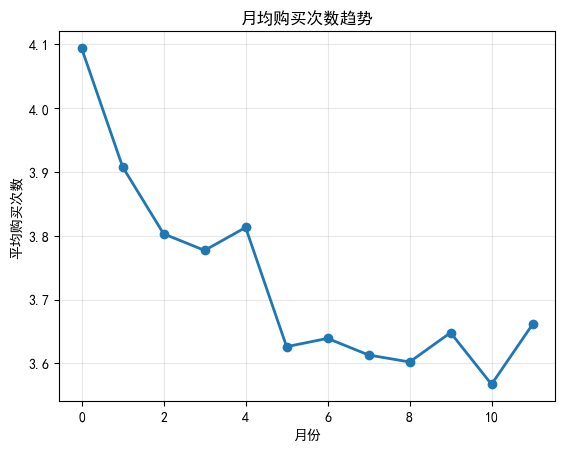

In [6]:
# 子图2：平均购买次数趋势
# plt.subplot(2, 3, 2)
monthly_avg = df_customers.groupby('month')['purchase_count'].mean()
monthly_avg.plot(marker='o', linewidth=2)
plt.title('月均购买次数趋势')
plt.xlabel('月份')
plt.ylabel('平均购买次数')
plt.grid(True, alpha=0.3)
plt.show()

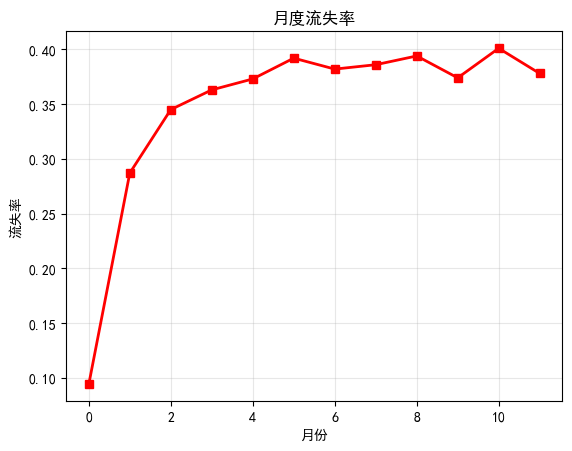

In [7]:
# 子图3：客户流失率
# plt.subplot(2, 3, 3)
churn_rate = df_customers[df_customers['state'] == 2].groupby('month').size() / n_customers
churn_rate.plot(marker='s', color='red', linewidth=2)
plt.title('月度流失率')
plt.xlabel('月份')
plt.ylabel('流失率')
plt.grid(True, alpha=0.3)
plt.show()

# 3. 构建马尔可夫模型

In [8]:
def build_transition_matrix(df, customer_col='customer_id', 
                          state_col='state', time_col='month'):
    """从客户数据构建转移概率矩阵"""
    transitions = []
    
    # 对每个客户追踪状态转移
    for customer_id in df[customer_col].unique():
        customer_df = df[df[customer_col] == customer_id].sort_values(time_col)
        states = customer_df[state_col].values
        
        for i in range(len(states) - 1):
            transitions.append((states[i], states[i+1]))
    
    # 统计转移次数
    n_states = len(customer_states)
    transition_counts = np.zeros((n_states, n_states))
    
    for from_state, to_state in transitions:
        transition_counts[from_state, to_state] += 1
    
    # 计算转移概率
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        row_sum = transition_counts[i].sum()
        if row_sum > 0:
            transition_matrix[i] = transition_counts[i] / row_sum
    
    return transition_matrix, transition_counts

# 使用前8个月的数据训练模型

In [9]:
# 使用前8个月的数据训练模型
train_months = 8
train_data = df_customers[df_customers['month'] < train_months]
test_data = df_customers[df_customers['month'] >= train_months]

estimated_matrix, counts = build_transition_matrix(train_data)

print("\n估计的客户状态转移矩阵：")
transition_df = pd.DataFrame(
    estimated_matrix,
    index=[customer_states[i] for i in range(len(customer_states))],
    columns=[customer_states[i] for i in range(len(customer_states))]
)
print(transition_df.round(3))
print(transition_df.head())


估计的客户状态转移矩阵：
       高频购买   低频购买     流失
高频购买  0.707  0.195  0.098
低频购买  0.198  0.513  0.289
流失    0.098  0.192  0.709
          高频购买      低频购买        流失
高频购买  0.706866  0.195423  0.097711
低频购买  0.197833  0.513242  0.288925
流失    0.098390  0.192308  0.709302


# 子图4：转移概率热力图

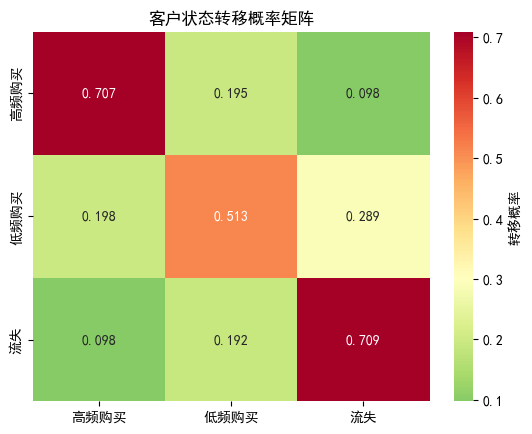

In [10]:
# 子图4：转移概率热力图
# plt.subplot(2, 3, 4)
sns.heatmap(estimated_matrix, annot=True, fmt='.3f',
            xticklabels=list(customer_states.values()),
            yticklabels=list(customer_states.values()),
            cmap='RdYlGn_r', center=0.3,
            cbar_kws={'label': '转移概率'})
plt.title('客户状态转移概率矩阵')
plt.show()

# 4. 客户价值分析

In [11]:

def calculate_customer_lifetime_value(transition_matrix, state_values, 
                                    discount_rate=0.1, n_periods=12):
    """计算不同状态客户的生命周期价值"""
    n_states = len(state_values)
    
    # 构建价值矩阵
    value_matrix = np.zeros((n_periods, n_states))
    value_matrix[0] = state_values
    
    # 计算未来各期的期望价值
    for t in range(1, n_periods):
        # 考虑状态转移和折现
        current_prob = np.eye(n_states)
        for _ in range(t):
            current_prob = current_prob @ transition_matrix
        
        discounted_values = state_values * (1 / (1 + discount_rate)) ** t
        value_matrix[t] = current_prob @ discounted_values
    
    # 计算总的生命周期价值
    clv = value_matrix.sum(axis=0)
    
    return clv, value_matrix



# 定义各状态的月度价值（平均订单价值 × 购买次数）

In [12]:

state_monthly_values = np.array([900, 250, 0])  # 高频、低频、流失

clv, value_trajectory = calculate_customer_lifetime_value(
    estimated_matrix, state_monthly_values
)

print("\n客户生命周期价值（CLV）：")
for i, state in customer_states.items():
    print(f"{state}: ¥{clv[i]:.2f}")


客户生命周期价值（CLV）：
高频购买: ¥3906.50
低频购买: ¥2500.17
流失: ¥1890.18


# 子图5：CLV轨迹

C:\Users\zm\.conda\envs\pys\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 165 (\N{YEN SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


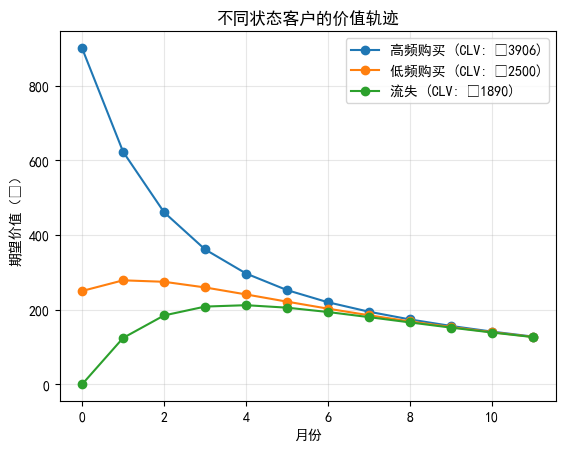

In [13]:
# 子图5：CLV轨迹
# plt.subplot(2, 3, 5)
months = range(12)
for i, state in customer_states.items():
    plt.plot(months, value_trajectory[:, i], marker='o', 
             label=f'{state} (CLV: ¥{clv[i]:.0f})')

plt.xlabel('月份')
plt.ylabel('期望价值（¥）')
plt.title('不同状态客户的价值轨迹')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. 营销策略优化

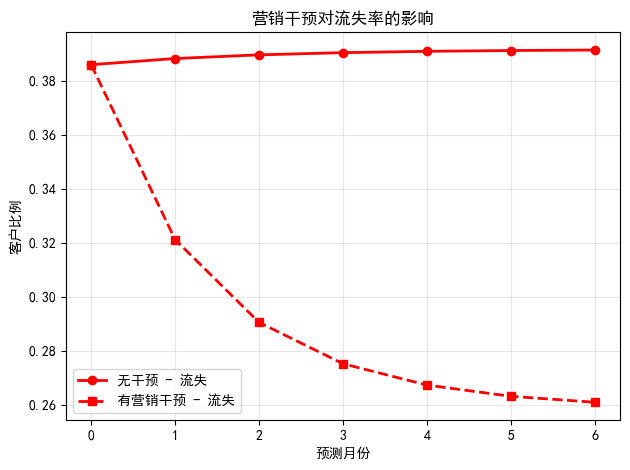

In [14]:
# 5. 营销策略优化
def simulate_marketing_intervention(transition_matrix, intervention_effect,
                                  target_state=2, n_customers=1000, n_months=6):
    """模拟营销干预的效果"""
    # 修改转移矩阵以反映营销效果
    modified_matrix = transition_matrix.copy()
    
    # 营销效果：降低流失概率，提高激活概率
    for state in range(len(customer_states)):
        if modified_matrix[state, target_state] > intervention_effect:
            # 减少流失概率
            modified_matrix[state, target_state] -= intervention_effect
            # 增加到低频或高频的概率
            if state == 2:  # 如果是流失状态
                modified_matrix[state, 1] += intervention_effect * 0.7
                modified_matrix[state, 0] += intervention_effect * 0.3
            else:
                modified_matrix[state, 1-state] += intervention_effect
    
    # 模拟两种场景
    scenarios = {
        '无干预': transition_matrix,
        '有营销干预': modified_matrix
    }
    
    results = {}
    for scenario_name, matrix in scenarios.items():
        # 初始状态分布（基于当前数据）
        current_dist = df_customers[df_customers['month'] == train_months-1]['state'].value_counts(normalize=True).sort_index().values
        
        # 模拟未来状态分布
        future_dists = [current_dist]
        for _ in range(n_months):
            current_dist = current_dist @ matrix
            future_dists.append(current_dist)
        
        results[scenario_name] = np.array(future_dists)
    
    return results

# 模拟营销干预效果（减少10%的流失概率）
intervention_results = simulate_marketing_intervention(
    estimated_matrix, intervention_effect=0.1
)

# 子图6：营销效果对比
# plt.subplot(2, 3, 6)
months = range(7)
colors = ['green', 'orange', 'red']
linestyles = ['-', '--']

for j, (scenario, dists) in enumerate(intervention_results.items()):
    for i, state in customer_states.items():
        if i == 2:  # 只显示流失率
            plt.plot(months, dists[:, i], 
                    color=colors[i], linestyle=linestyles[j],
                    marker='o' if j == 0 else 's',
                    label=f'{scenario} - {state}', linewidth=2)

plt.xlabel('预测月份')
plt.ylabel('客户比例')
plt.title('营销干预对流失率的影响')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 个体客户预测

In [15]:
# 6. 个体客户预测
def predict_customer_state(customer_history, transition_matrix, n_months=3):
    """预测单个客户未来的状态"""
    current_state = customer_history[-1]
    predictions = []
    probabilities = []
    
    # 当前状态的概率向量
    state_prob = np.zeros(len(customer_states))
    state_prob[current_state] = 1.0
    
    for _ in range(n_months):
        # 计算下个月的状态概率
        state_prob = state_prob @ transition_matrix
        probabilities.append(state_prob.copy())
        
        # 预测最可能的状态
        predicted_state = np.argmax(state_prob)
        predictions.append(predicted_state)
    
    return predictions, probabilities

# 选择几个典型客户进行预测
sample_customers = [0, 10, 50, 100]
print("\n个体客户预测示例：")

for cust_id in sample_customers:
    # 获取客户历史
    cust_data = train_data[train_data['customer_id'] == cust_id].sort_values('month')
    history = cust_data['state'].values
    
    # 预测未来3个月
    pred_states, pred_probs = predict_customer_state(history, estimated_matrix, 3)
    
    print(f"\n客户 {cust_id}:")
    print(f"  历史状态: {[customer_states[s] for s in history[-3:]]}")
    print(f"  预测状态: {[customer_states[s] for s in pred_states]}")
    print(f"  流失概率: {[p[2] for p in pred_probs]}")



个体客户预测示例：

客户 0:
  历史状态: ['流失', '流失', '流失']
  预测状态: ['流失', '流失', '流失']
  流失概率: [np.float64(0.7093023255813954), np.float64(0.5682860140599056), np.float64(0.4939016416427403)]

客户 10:
  历史状态: ['流失', '低频购买', '低频购买']
  预测状态: ['低频购买', '流失', '流失']
  流失概率: [np.float64(0.28892455858747995), np.float64(0.3725537077775157), np.float64(0.3939475329234464)]

客户 50:
  历史状态: ['高频购买', '高频购买', '流失']
  预测状态: ['流失', '流失', '流失']
  流失概率: [np.float64(0.7093023255813954), np.float64(0.5682860140599056), np.float64(0.4939016416427403)]

客户 100:
  历史状态: ['流失', '流失', '流失']
  预测状态: ['流失', '流失', '流失']
  流失概率: [np.float64(0.7093023255813954), np.float64(0.5682860140599056), np.float64(0.4939016416427403)]


# 7. 模型评估

In [16]:
# 7. 模型评估
def evaluate_predictions(test_data, transition_matrix):
    """评估模型的预测准确率"""
    correct_predictions = 0
    total_predictions = 0
    
    # 按客户分组
    for customer_id in test_data['customer_id'].unique():
        cust_test = test_data[test_data['customer_id'] == customer_id].sort_values('month')
        
        if len(cust_test) < 2:
            continue
        
        # 使用第一个测试月的状态预测后续
        initial_state = cust_test.iloc[0]['state']
        actual_states = cust_test.iloc[1:]['state'].values
        
        # 预测
        pred_states, _ = predict_customer_state([initial_state], 
                                               transition_matrix, 
                                               len(actual_states))
        
        # 计算准确率
        correct_predictions += sum(pred_states == actual_states)
        total_predictions += len(actual_states)
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

accuracy = evaluate_predictions(test_data, estimated_matrix)
print(f"\n模型预测准确率: {accuracy:.2%}")


模型预测准确率: 51.53%


In [17]:
# 8. 策略建议
print("\n基于分析的营销策略建议：")
print("\n1. 客户细分策略：")
for state, clv_value in zip(customer_states.values(), clv):
    print(f"   - {state}客户 (CLV: ¥{clv_value:.0f})")

print("\n2. 重点关注对象：")
print("   - 低频购买客户：流失风险高（30%），需要激活计划")
print("   - 新流失客户：仍有10%概率重新激活")

print("\n3. 建议的营销措施：")
print("   - 对低频客户：个性化推荐、限时优惠")
print("   - 对高频客户：VIP服务、忠诚度奖励")
print("   - 对流失客户：召回邮件、特别折扣")

# 保存分析结果
analysis_results = {
    'transition_matrix': estimated_matrix,
    'customer_lifetime_values': clv,
    'model_accuracy': accuracy,
    'intervention_simulation': intervention_results
}

print("\n分析完成！所有结果已保存在 analysis_results 字典中。")


基于分析的营销策略建议：

1. 客户细分策略：
   - 高频购买客户 (CLV: ¥3906)
   - 低频购买客户 (CLV: ¥2500)
   - 流失客户 (CLV: ¥1890)

2. 重点关注对象：
   - 低频购买客户：流失风险高（30%），需要激活计划
   - 新流失客户：仍有10%概率重新激活

3. 建议的营销措施：
   - 对低频客户：个性化推荐、限时优惠
   - 对高频客户：VIP服务、忠诚度奖励
   - 对流失客户：召回邮件、特别折扣

分析完成！所有结果已保存在 analysis_results 字典中。
